In [1]:
import sys
sys.path.append('../../..')
from viz.match_data import extract_match_complete
from viz.pass_network import plot_pass_network
from viz.pass_analysis import plot_pass_flow, plot_pass_hull
from viz.shot_xg import plot_shot_xg
from viz.shot_map_report import plot_shot_report
from viz.stats_table import create_player_analysis_complete
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Datos del partido
WS_ID = 1913901
US_ID = 29173
LEAGUE = 'ESP-La Liga'
SEASON = '25-26'
HOME_TEAM = 'Villarreal'
AWAY_TEAM = 'Girona'
MATCH_DATE = '2025-08-24'

# Extracción completa de datos
result = extract_match_complete(
    ws_id=WS_ID,
    us_id=US_ID,
    league=LEAGUE,
    season=SEASON,
    home_team=HOME_TEAM,
    away_team=AWAY_TEAM,
    match_date=MATCH_DATE
)


Extracting: Villarreal vs Girona (2025-08-24)
--------------------------------------------------


In [ ]:
fig_network = plot_pass_network(
    network_csv_path='../../../viz/data/player_network.csv',
    info_csv_path='../../../viz/data/match_info.csv',
    aggregates_csv_path='../../../viz/data/match_aggregates.csv',
    home_logo_path='../../logos/LaLiga/Villarreal CF.png',
    away_logo_path='../../logos/LaLiga/Girona FC.png'
)

NameError: name 'plot_pass_network' is not defined

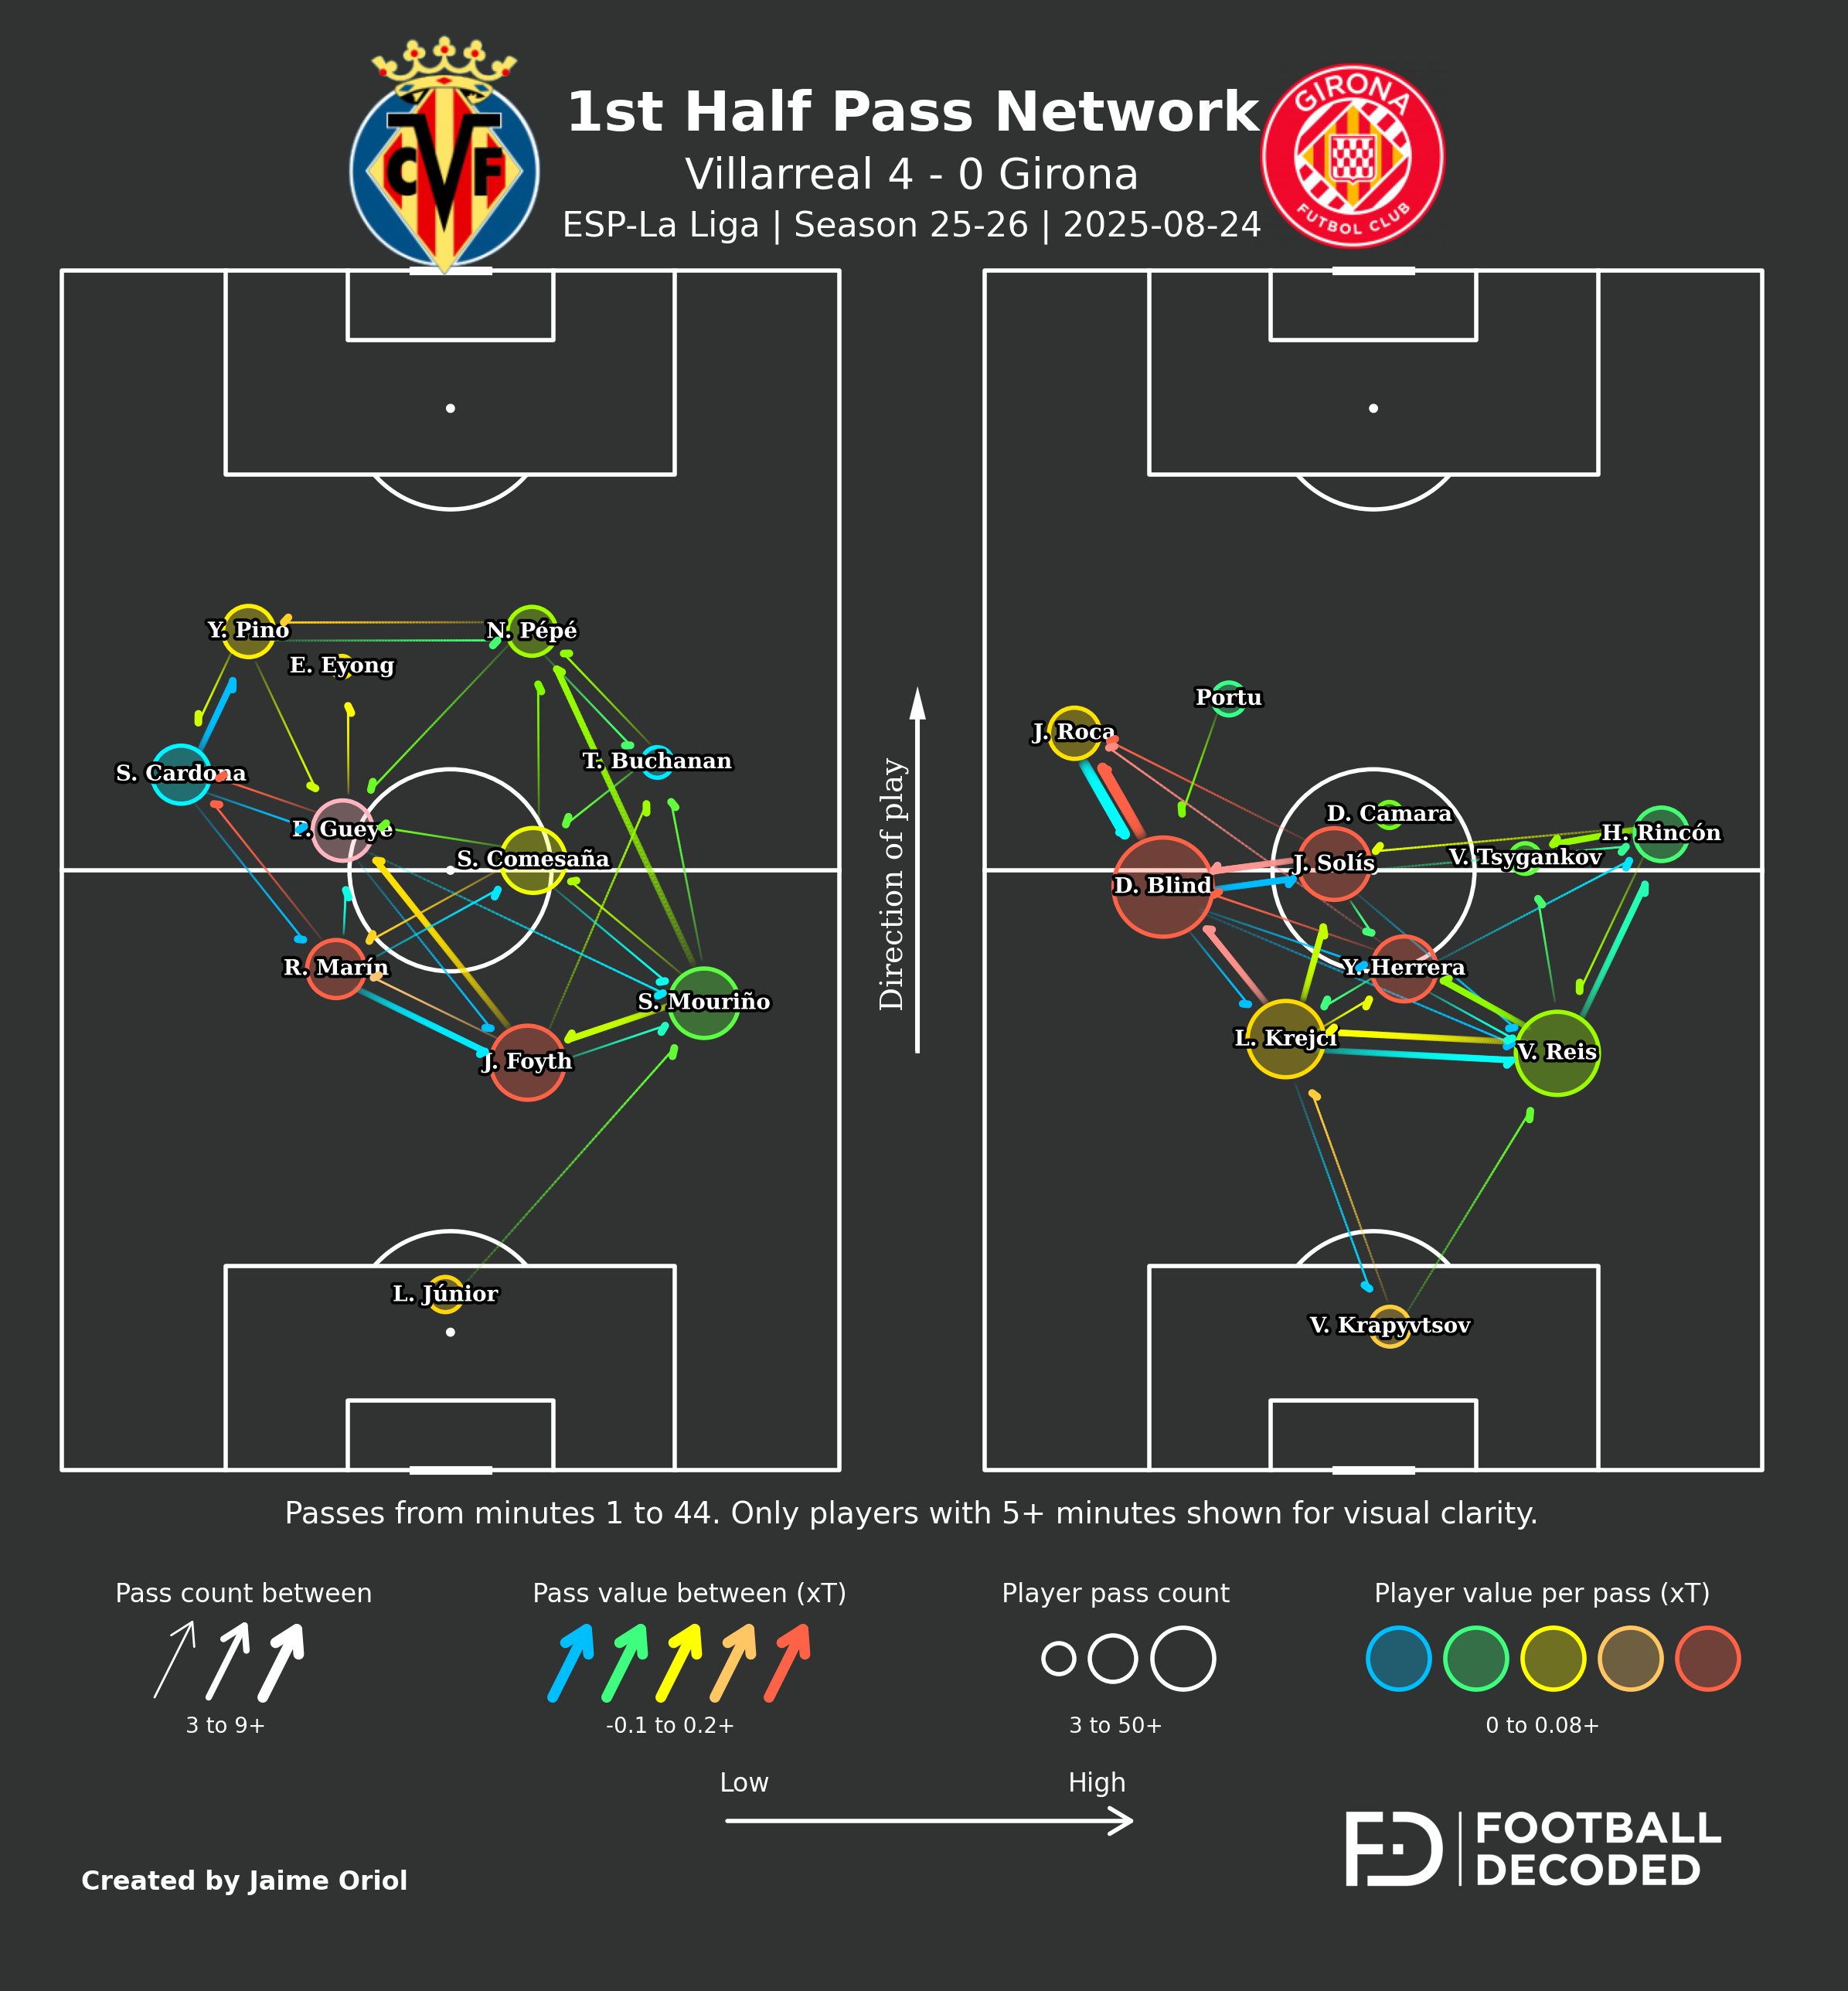

In [ ]:
# Pass network primer tiempo (jugadores >5 minutos primer tiempo)
from viz.pass_network import plot_pass_network_first_half
fig_network_44 = plot_pass_network_first_half(
    network_csv_path='../../../viz/data/player_network.csv',
    info_csv_path='../../../viz/data/match_info.csv',
    aggregates_csv_path='../../../viz/data/match_aggregates.csv',
    home_logo_path='../../logos/LaLiga/Villarreal CF.png',
    away_logo_path='../../logos/LaLiga/Girona FC.png'
)

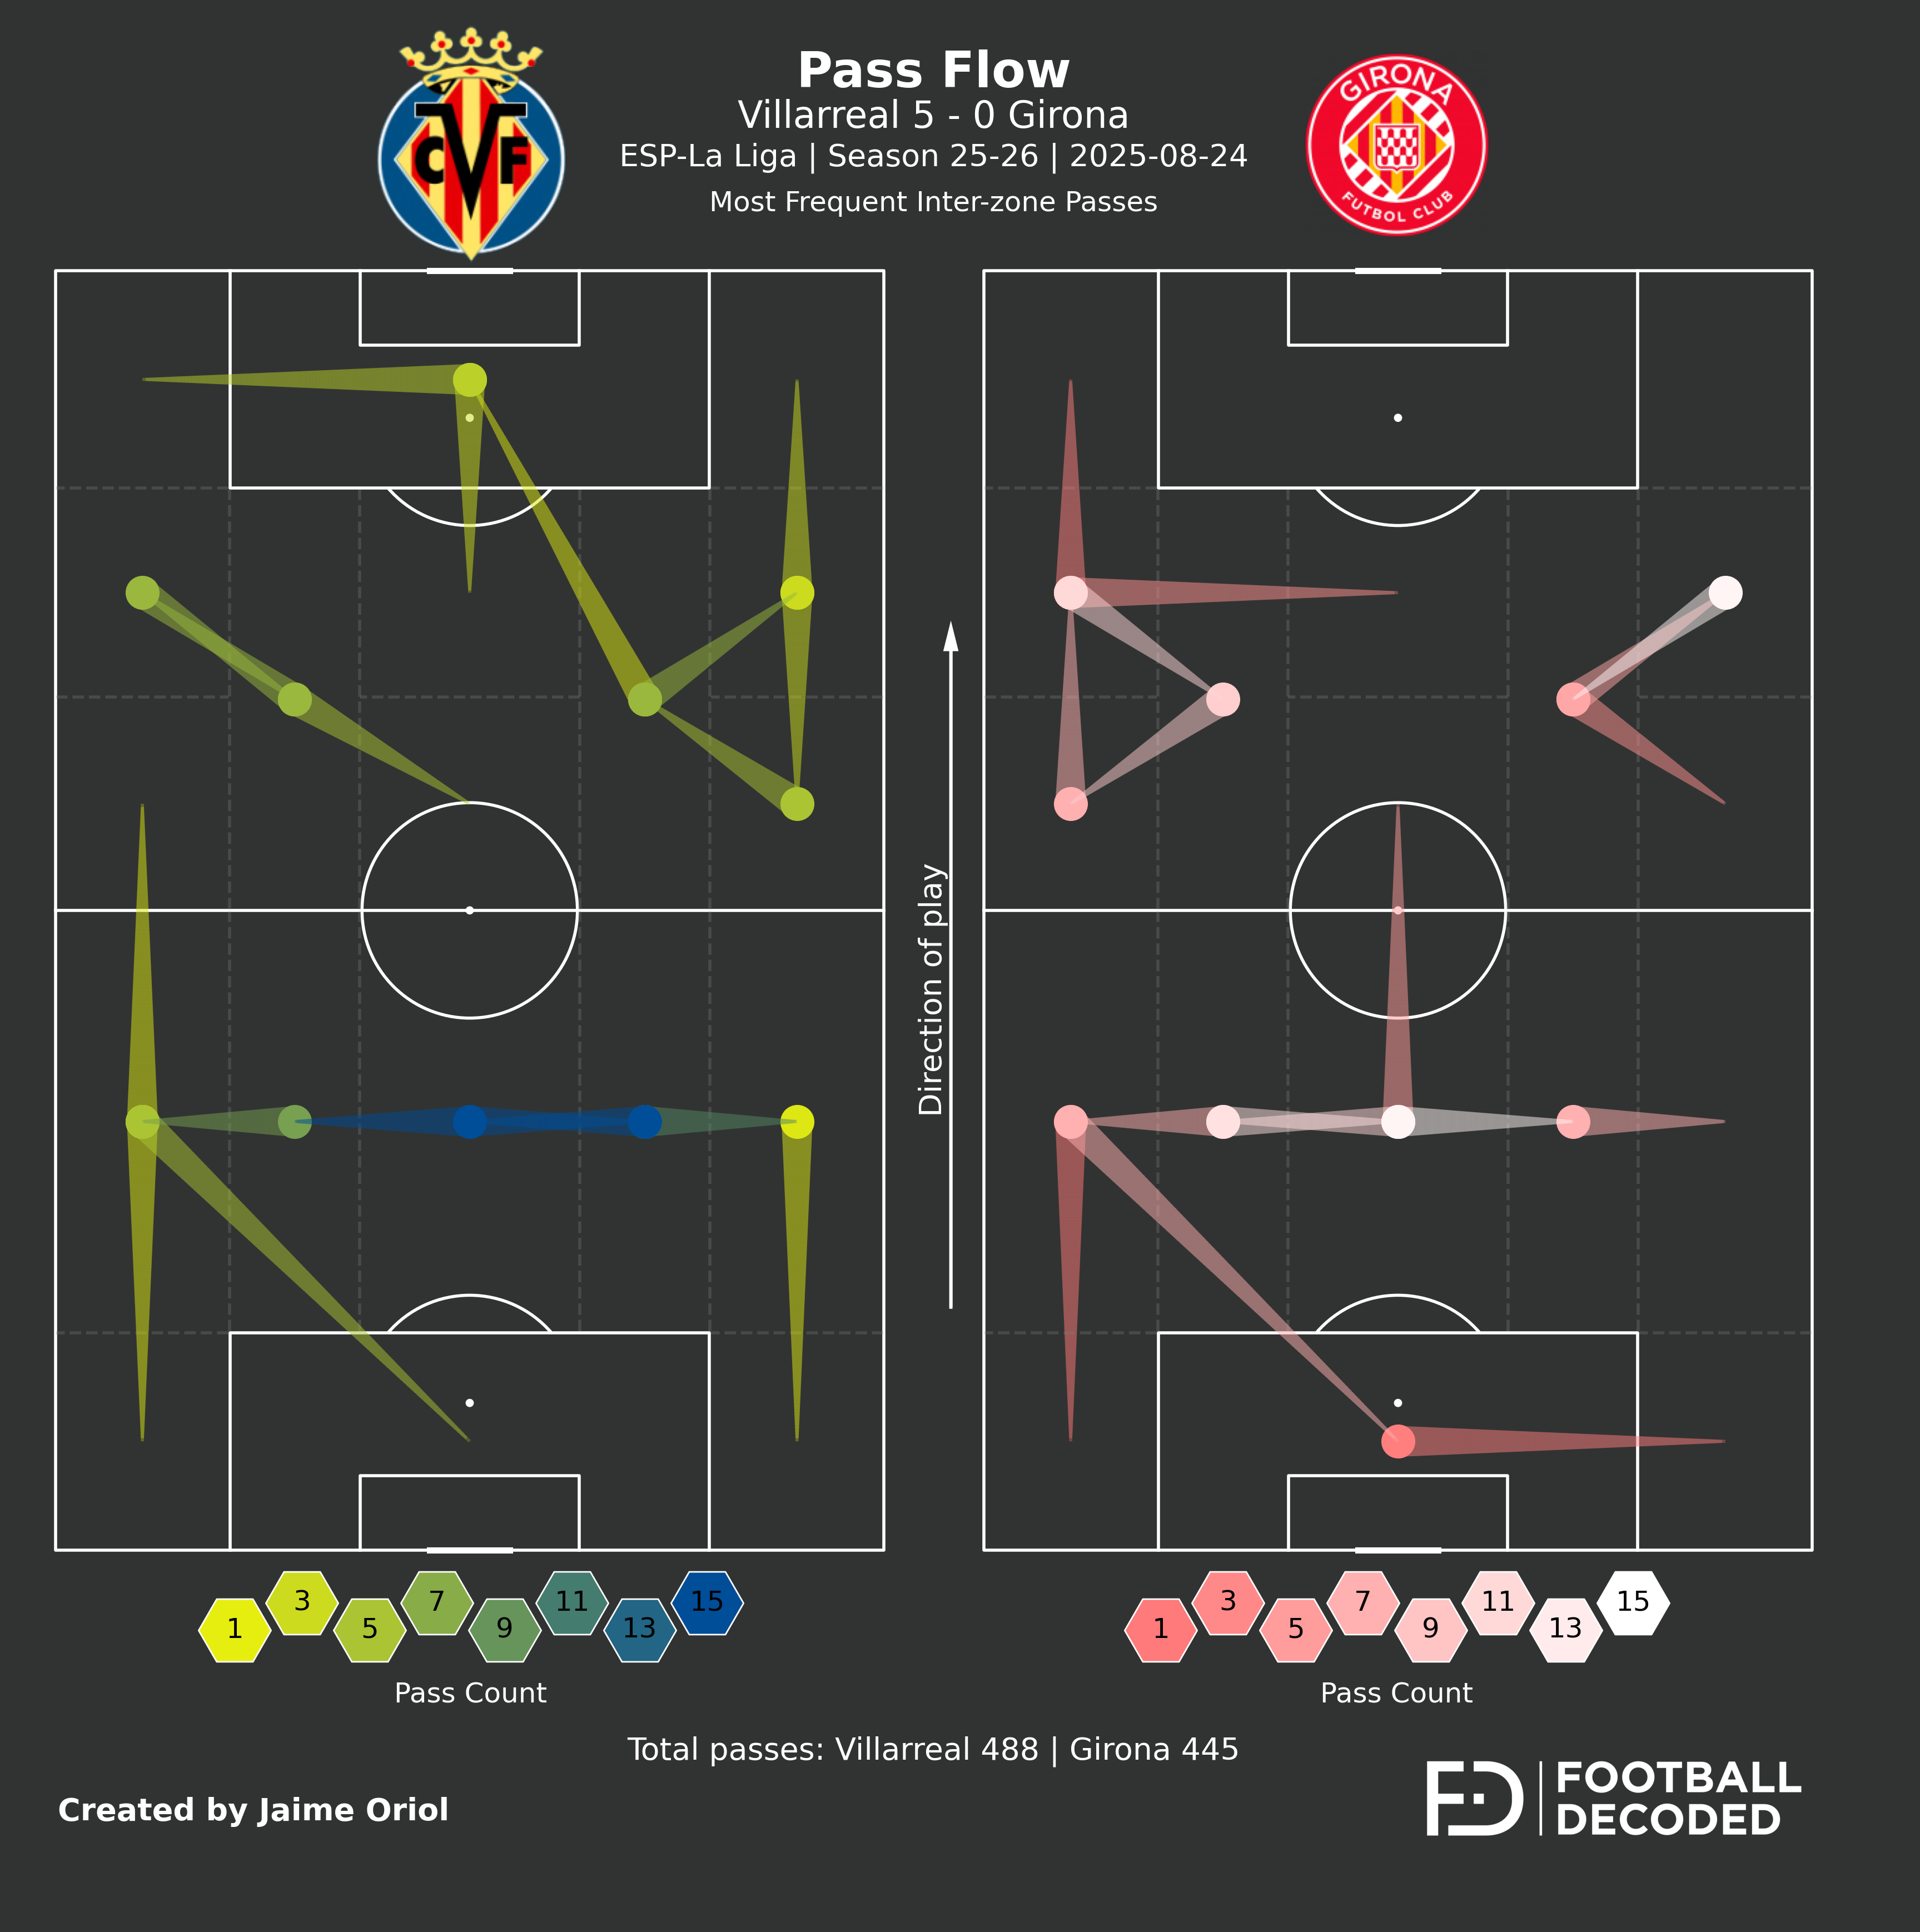

In [ ]:
# Pass Flow
fig_flow = plot_pass_flow(
    events_csv_path='../../../viz/data/match_events.csv',
    info_csv_path='../../../viz/data/match_info.csv',
    home_colors=['#FFFF00', '#004D98'],
    away_colors=['#FF6B6B', '#FFFFFF'],
    home_logo_path='../../logos/LaLiga/Villarreal CF.png',
    away_logo_path='../../logos/LaLiga/Girona FC.png'
)

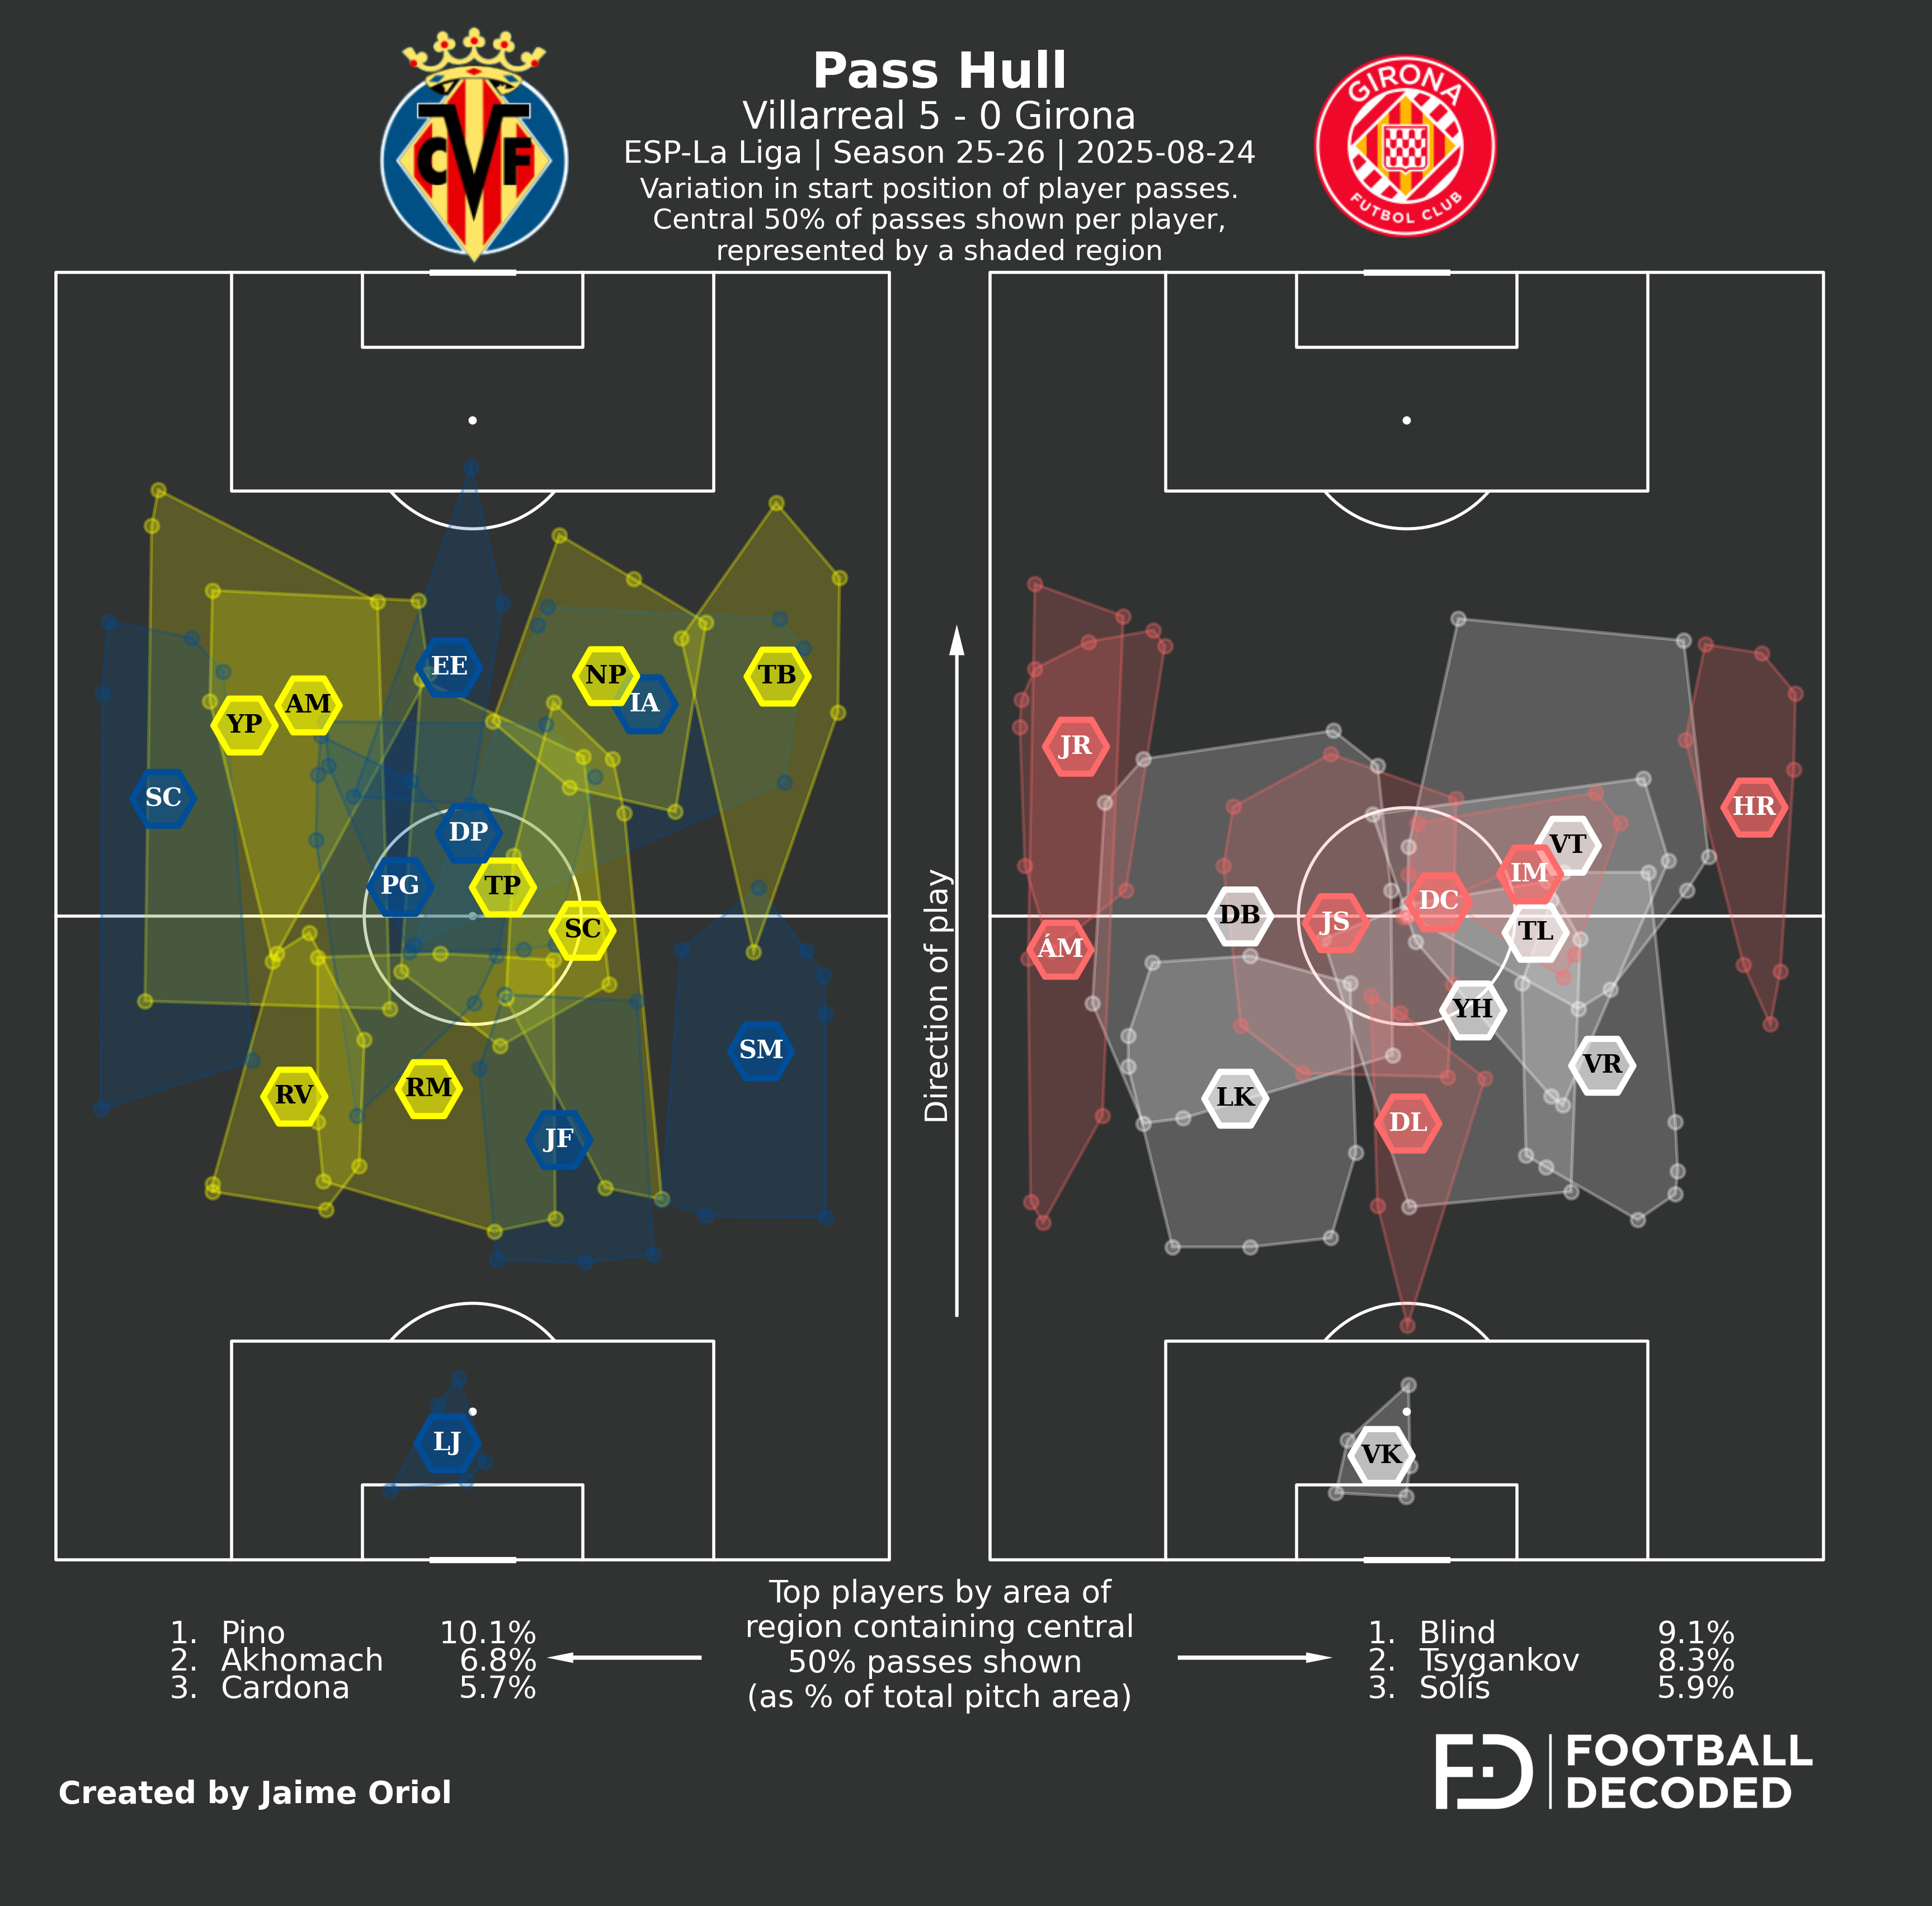

In [ ]:
# Pass Hull
fig_hull = plot_pass_hull(
    events_csv_path='../../../viz/data/match_events.csv',
    info_csv_path='../../../viz/data/match_info.csv',
    aggregates_csv_path='../../../viz/data/match_aggregates.csv',
    home_colors=['#FFFF00', '#004D98'],
    away_colors=['#FF6B6B', '#FFFFFF'],
    home_logo_path='../../logos/LaLiga/Villarreal CF.png',
    away_logo_path='../../logos/LaLiga/Girona FC.png'
)

Disparos: 24 | Goles: 5 | xG: 3.143


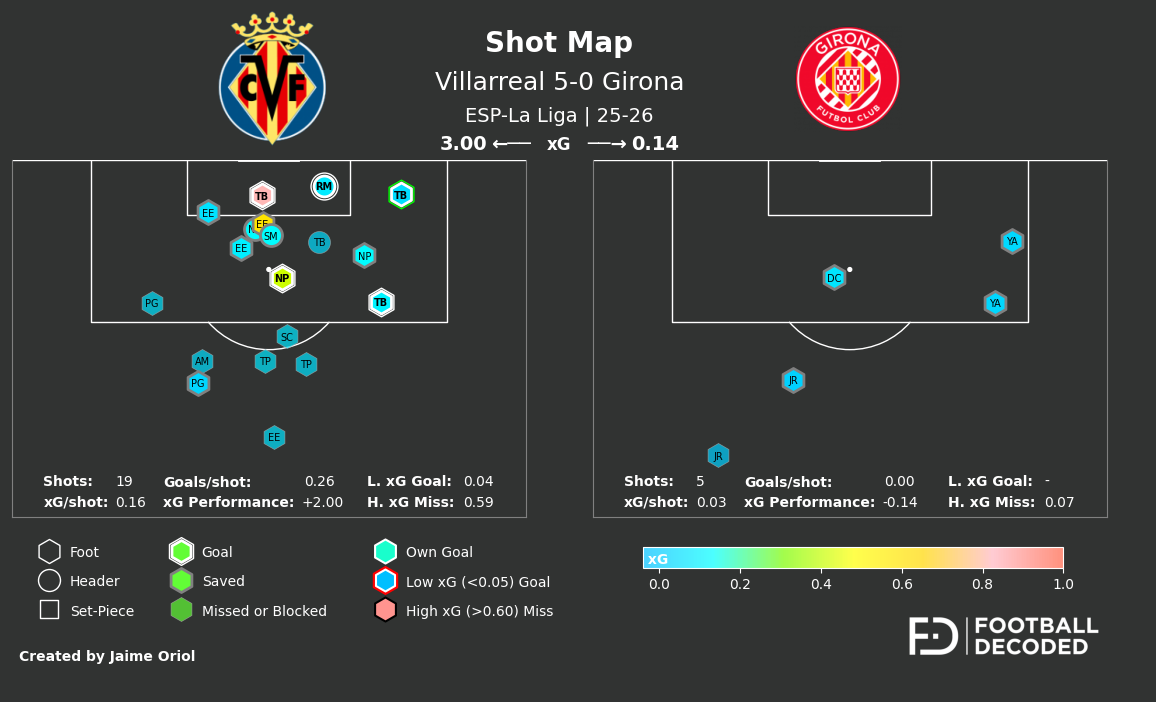

In [ ]:
# Preparar datos de disparos
def create_shots_csv():
    events = pd.read_csv('../../../viz/data/match_events.csv')
    shots = events[events['event_type'].str.contains('Shot|Goal', case=False, na=False)].copy()
    shots['is_goal'] = shots['event_type'] == 'Goal'
    shots['body_part'] = shots['qualifiers'].str.contains('Head', na=False).map({True: 'Head', False: 'Foot'})
    shots['xg'] = pd.to_numeric(shots['xg'], errors='coerce').fillna(0.0)
    shots.to_csv('../../../viz/data/shots_temp.csv', index=False)
    print(f"Disparos: {len(shots)} | Goles: {shots['is_goal'].sum()} | xG: {shots['xg'].sum():.3f}")
    return shots

shots_data = create_shots_csv()

# Shot Map Report
fig_report = plot_shot_report(
    csv_path='../../../viz/data/shots_temp.csv',
    home_logo_path='../../logos/LaLiga/Villarreal CF.png',
    away_logo_path='../../logos/LaLiga/Girona FC.png',
    season='25-26'
)

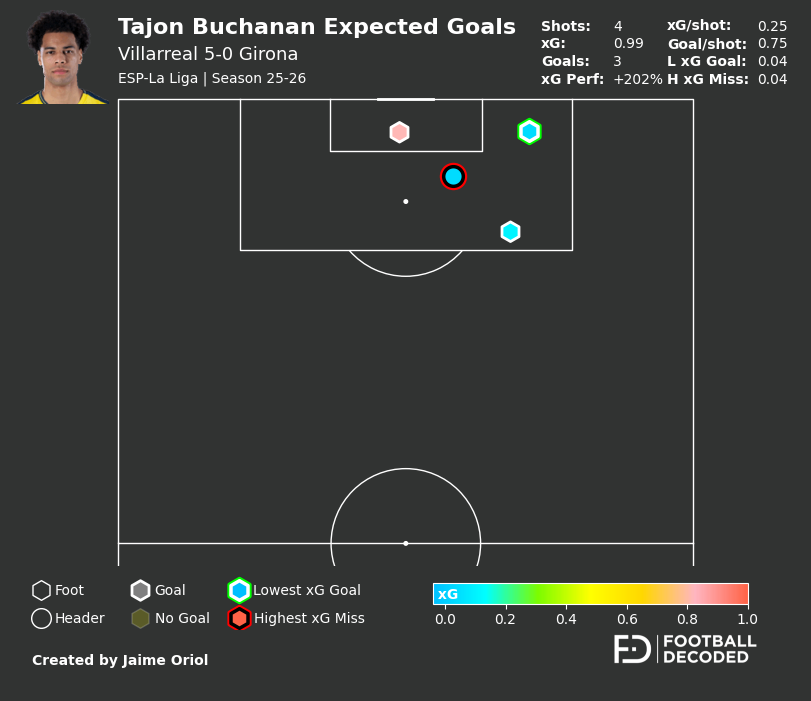

In [ ]:
# Visualización xG
fig_buchanan = plot_shot_xg(
    csv_path='../../../viz/data/shots_temp.csv',
    filter_by='Tajon Buchanan',
    logo_path='../../caras/villareal/Buchanan.png',
    title_text='Tajon Buchanan Expected Goals',
    subtitle_text='Villarreal 5-0 Girona',
    subsubtitle_text='ESP-La Liga | Season 25-26'
)

In [ ]:
# FINAL DEFINITIVE: Using ONLY reliable data sources after verification
def extract_custom_stats(player_name, events_df, aggregates_df):
    """
    Extract player statistics using ONLY VERIFIED reliable data sources.
    
    DISCOVERY: match_events.csv has INCORRECT assist labels (Pépé shows 2 assists but had 0 real assists)
    SOLUTION: Use aggregates.csv for ALL processed metrics, events.csv ONLY for basic event counts
    """
    player_events = events_df[events_df['player'] == player_name]
    
    # Get aggregates data (MOST RELIABLE source for calculated metrics)
    player_agg = aggregates_df[
        aggregates_df['entity_name'].str.contains(player_name, case=False, na=False)
    ]
    if len(player_agg) == 0:
        agg_data = {col: 0 for col in aggregates_df.columns}
    else:
        agg_data = player_agg.iloc[0]
    
    # BASIC EVENT COUNTS (reliable from events)
    goals = len(player_events[player_events['event_type'] == 'Goal'])
    saved_shots = len(player_events[player_events['event_type'] == 'SavedShot']) 
    missed_shots = len(player_events[player_events['event_type'] == 'MissedShots'])
    shots_total = goals + saved_shots + missed_shots
    
    # SUCCESS RATES (reliable from events where is_successful exists)
    shots_on_target = goals + saved_shots
    shots_on_target_pct = (shots_on_target / shots_total * 100) if shots_total > 0 else 0
    
    # Take-ons
    takeon_events = player_events[player_events['event_type'] == 'TakeOn']
    takeons_total = len(takeon_events)
    takeons_successful = len(takeon_events[takeon_events['is_successful'] == True])
    takeon_success_pct = (takeons_successful / takeons_total * 100) if takeons_total > 0 else 0
    
    # Tackles  
    tackle_events = player_events[player_events['event_type'] == 'Tackle']
    tackles_total = len(tackle_events)
    tackles_successful = len(tackle_events[tackle_events['is_successful'] == True])
    tackle_success_pct = (tackles_successful / tackles_total * 100) if tackles_total > 0 else 0
    
    # Aerial duels
    aerial_events = player_events[player_events['event_type'] == 'Aerial']
    aerials_total = len(aerial_events)
    aerials_successful = len(aerial_events[aerial_events['is_successful'] == True])
    aerial_success_pct = (aerials_successful / aerials_total * 100) if aerials_total > 0 else 0
    
    # Crosses
    cross_events = player_events[player_events['is_cross'] == True]
    crosses_total = len(cross_events)
    crosses_successful = len(cross_events[cross_events['is_successful'] == True])
    cross_success_pct = (crosses_successful / crosses_total * 100) if crosses_total > 0 else 0
    
    return {
        # Basic counts from events (reliable)
        'goals': goals,
        'xg_total': player_events['xg'].fillna(0).sum(),
        
        # SUCCESS/ATTEMPTS from events (reliable)
        'shots_on_target': shots_on_target,
        'shots_total': shots_total, 
        'shots_on_target_pct': shots_on_target_pct,
        
        'takeons_successful': takeons_successful,
        'takeons_total': takeons_total,
        'takeon_success_pct': takeon_success_pct,
        
        'tackles_successful': tackles_successful,
        'tackles_total': tackles_total,
        'tackle_success_pct': tackle_success_pct,
        
        'aerials_successful': aerials_successful,
        'aerials_total': aerials_total,
        'aerial_success_pct': aerial_success_pct,
        
        'crosses_successful': crosses_successful,
        'crosses_total': crosses_total,
        'cross_success_pct': cross_success_pct,
        
        # Simple event counts (reliable)
        'interceptions': len(player_events[player_events['event_type'] == 'Interception']),
        'clearances': len(player_events[player_events['event_type'] == 'Clearance']),
        'ball_recoveries': len(player_events[player_events['event_type'] == 'BallRecovery']),
        'headers': len(player_events[player_events['is_header'] == True]),
        
        # CORRECTED: Use ONLY aggregates for processed metrics (MOST RELIABLE)
        'minutes_active': int(agg_data.get('minutes_active', 0)),
        'passes_completed': int(agg_data.get('passes_completed', 0)),
        'passes_attempted': int(agg_data.get('passes_attempted', 0)),
        'pass_completion_pct': agg_data.get('pass_completion_pct', 0),
        'progressive_passes': int(agg_data.get('progressive_passes', 0)),
        'box_entries': int(agg_data.get('box_entries', 0)),
        'key_passes': int(agg_data.get('key_passes', 0)),
        'xthreat_total': agg_data.get('xthreat_total', 0),
        'defensive_actions': int(agg_data.get('defensive_actions', 0)),
        'offensive_actions': int(agg_data.get('offensive_actions', 0)),
        'total_actions': int(agg_data.get('total_actions', 0)),
        
        # CORRECTED: Use AGGREGATES for assists (RELIABLE processed data)
        'assists': int(agg_data.get('passes_to_goal', 0)),  # REAL assists from aggregates
        'pre_assists': int(agg_data.get('pre_assists', 0))  # REAL pre-assists from aggregates
    }

# VERIFIED DATA RELIABILITY:
"""
MATCH_EVENTS.CSV - RELIABLE FOR:
✓ Basic event counts (Goals, Shots, TakeOns, Tackles, Aerials, Clearances, etc.)
✓ Success/failure rates where is_successful flag exists
✓ xG values, coordinates, timing

MATCH_AGGREGATES.CSV - MOST RELIABLE FOR:
✓ passes_to_goal (real assists - properly calculated)
✓ pre_assists (properly calculated)  
✓ Pass completion rates, progressive passes
✓ Box entries, key passes, xThreat totals
✓ Action counts (offensive/defensive)
✓ Minutes played

STRATEGY: Use aggregates.csv for ALL complex/processed metrics, events.csv only for basic counts
"""

'\nMATCH_EVENTS.CSV - RELIABLE FOR:\n✓ Basic event counts (Goals, Shots, TakeOns, Tackles, Aerials, Clearances, etc.)\n✓ Success/failure rates where is_successful flag exists\n✓ xG values, coordinates, timing\n\nMATCH_AGGREGATES.CSV - MOST RELIABLE FOR:\n✓ passes_to_goal (real assists - properly calculated)\n✓ pre_assists (properly calculated)  \n✓ Pass completion rates, progressive passes\n✓ Box entries, key passes, xThreat totals\n✓ Action counts (offensive/defensive)\n✓ Minutes played\n\nSTRATEGY: Use aggregates.csv for ALL complex/processed metrics, events.csv only for basic counts\n'

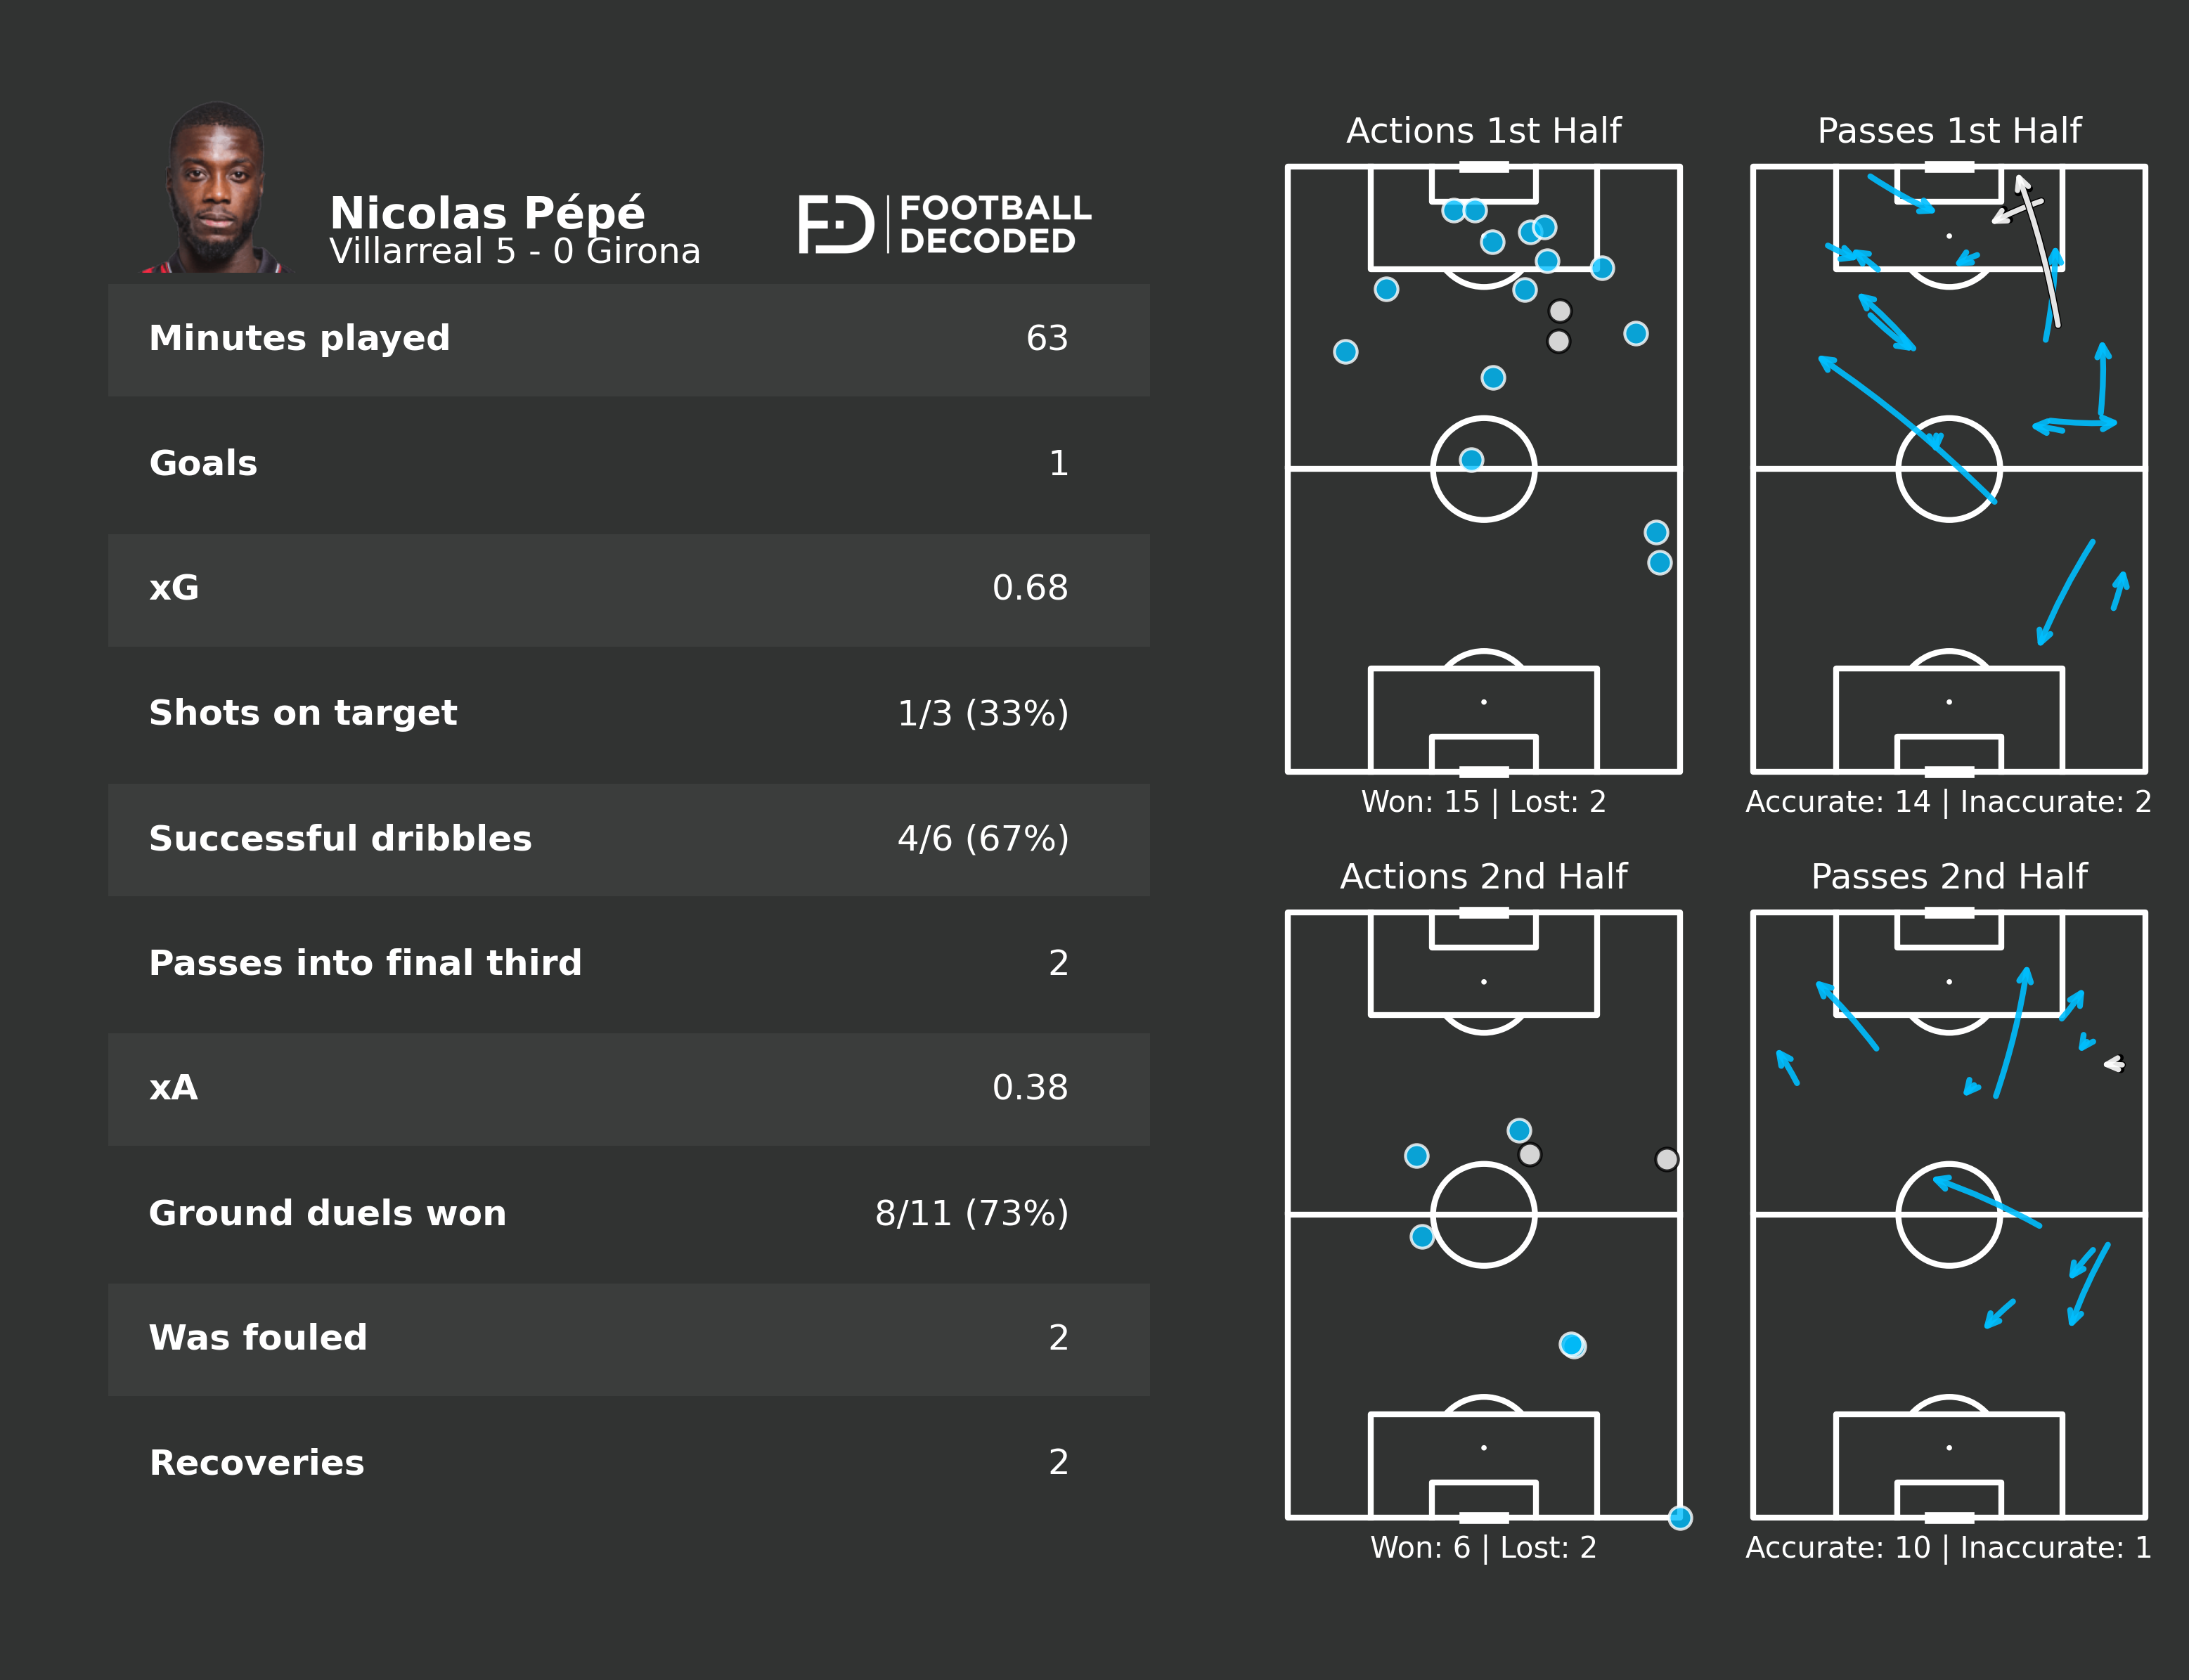

In [2]:
# 1. NICOLAS PÉPÉ (Delantero) - MÉTRICAS CONFIABLES VERIFICADAS
events = pd.read_csv('../../../viz/data/match_events.csv')
aggregates = pd.read_csv('../../../viz/data/match_aggregates.csv')


# MÉTRICAS CONFIABLES para delantero (evitando assists erróneos)
pepe_enriched = [
    ("Minutes played", "63"),
    ("Goals", "1"),
    ("xG", "0.68"),
    ("Shots on target", "1/3 (33%)"),
    ("Successful dribbles", "4/6 (67%)"), 
    ("Passes into final third", "2"),
    ("xA", "0.38"),
    ("Ground duels won", "8/11 (73%)"),
    ("Was fouled", "2"),
    ("Recoveries", "2")
]

# Crear análisis completo
fig_pepe = create_player_analysis_complete(
    player_name='Nicolas Pépé',
    team_name='Villarreal 5 - 0 Girona',
    enriched_metrics=pepe_enriched,
    events_df=events,
    player_image_path='../../caras/villareal/Pepe-2.png'
)

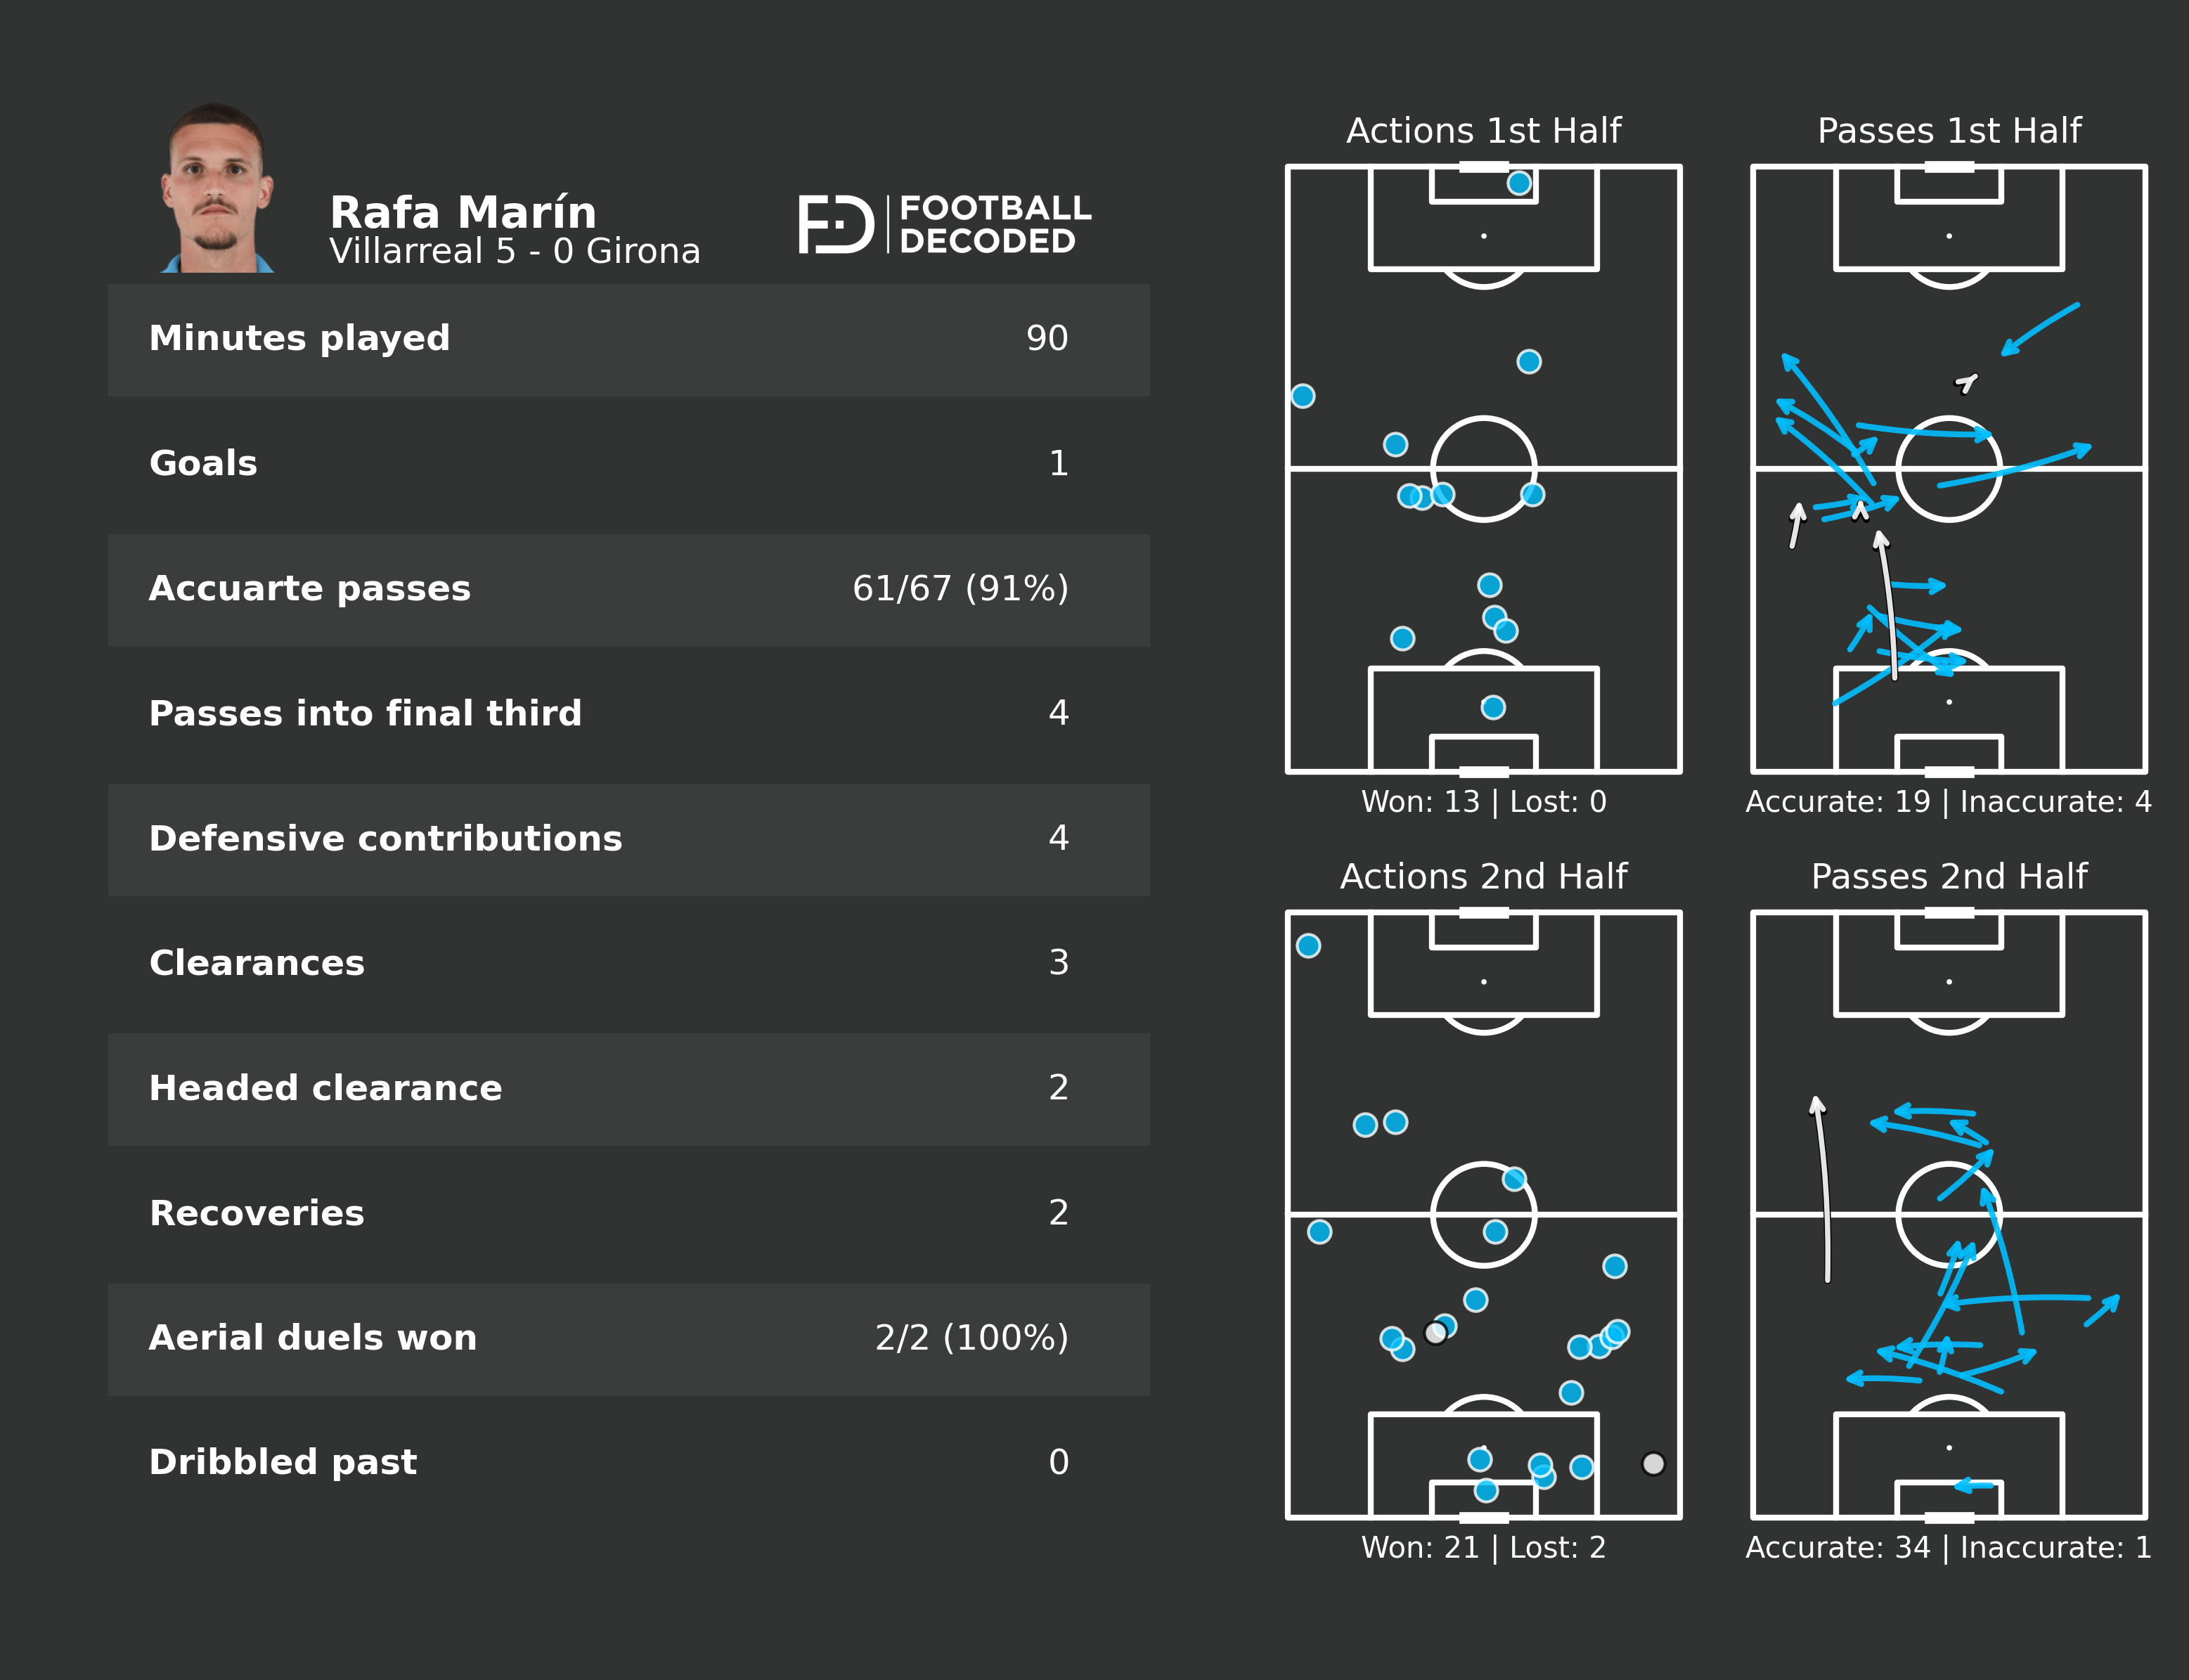

In [3]:
# MÉTRICAS CONFIABLES para defensa central (ACTUALIZADA: quitar interceptions+headers, añadir xThreat+total actions)
rafa_enriched = [
    ("Minutes played", "90"),
    ("Goals", "1"),
    ("Accuarte passes", "61/67 (91%)"),
    ("Passes into final third", "4"),
    ("Defensive contributions", "4"),
    ("Clearances", "3"),
    ("Headed clearance", "2"), 
    ("Recoveries", "2"),
    ("Aerial duels won", "2/2 (100%)"),
    ("Dribbled past", "0"),
]

# Crear análisis completo
fig_rafa = create_player_analysis_complete(
    player_name='Rafa Marín',
    team_name='Villarreal 5 - 0 Girona',
    enriched_metrics=rafa_enriched,
    events_df=events,
    player_image_path='../../caras/villareal/Marin.png'
)

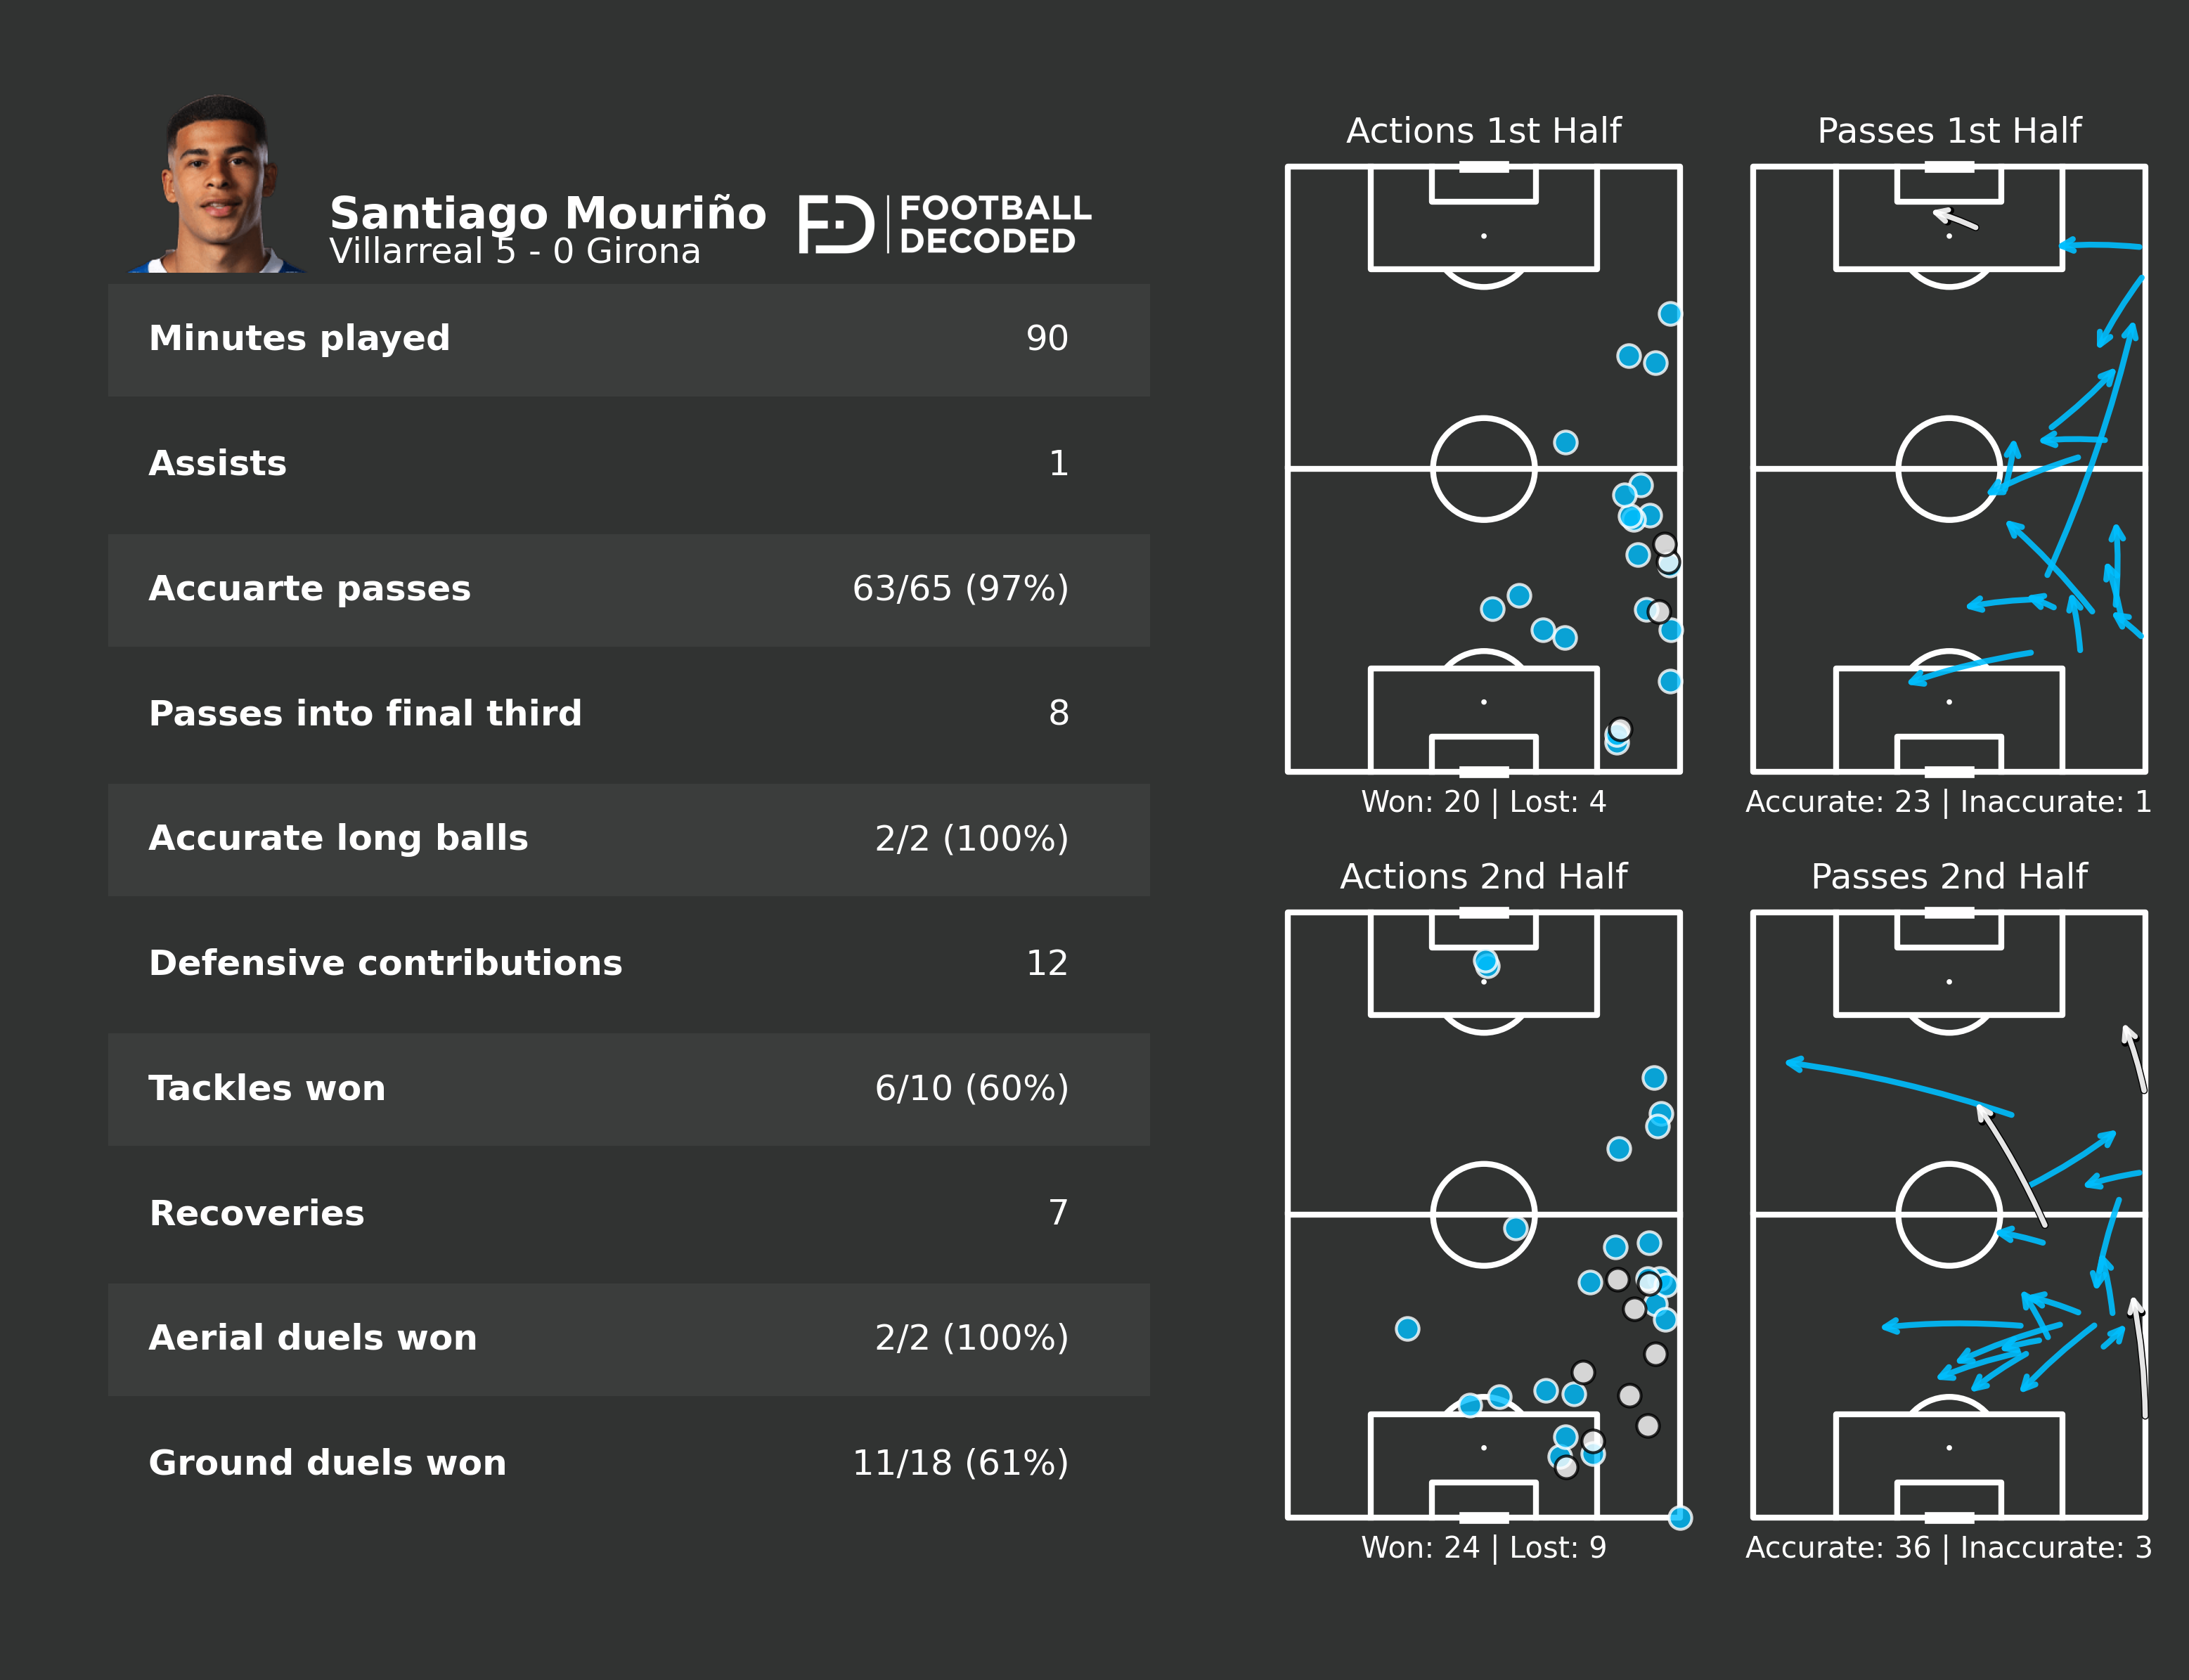

In [4]:
# MÉTRICAS CONFIABLES para lateral/defensa (HARDCODED: 1 assist real según marcador)
mourino_enriched = [
    ("Minutes played", "90"),
    ("Assists", "1"),
    ("Accuarte passes", "63/65 (97%)"),
    ("Passes into final third", "8"),
    ("Accurate long balls", "2/2 (100%)"), 
    ("Defensive contributions", "12"),
    ("Tackles won", "6/10 (60%)"),
    ("Recoveries", "7"),
    ("Aerial duels won", "2/2 (100%)"),
    ("Ground duels won", "11/18 (61%)"),
]

# Crear análisis completo
fig_mourino = create_player_analysis_complete(
    player_name='Santiago Mouriño',
    team_name='Villarreal 5 - 0 Girona',
    enriched_metrics=mourino_enriched,
    events_df=events,
    player_image_path='../../caras/villareal/Mouriño-2.png'
)